In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from fastai.vision import *
import torch

#from mrnet_orig import *
from mrnet_itemlist import *

#from ipywidgets import interact, Dropdown, IntSlider

%matplotlib notebook
plt.style.use('grayscale')

In [2]:
# run tree on my data to see its data structure
! tree -d ..

..
├── data
│   ├── train
│   │   ├── axial
│   │   ├── coronal
│   │   └── sagittal
│   └── valid
│       ├── axial
│       ├── coronal
│       └── sagittal
├── data24
│   ├── train
│   │   ├── axial
│   │   ├── coronal
│   │   └── sagittal
│   └── valid
│       ├── axial
│       ├── coronal
│       └── sagittal
└── mrnet-fastai
    ├── __pycache__
    ├── exp
    ├── models
    └── paper-code
        └── MRNet-master

24 directories


In [3]:
data_path = Path('../data24') # /data24 contains interpolated data where each case-plane has 24 slices

In [4]:
caselist = MRNetCaseList.from_folder(path=data_path)

In [5]:
type(caselist)

mrnet_itemlist.MRNetCaseList

In [6]:
caselist.items[:5] # items are Case numbers as 4-character strings

array(['0000', '0001', '0002', '0003', '0004'], dtype=object)

In [7]:
caselist.inner_df  # at this point, inner_df is an empty attribute, returning None, since caselist was 

Construct a DataFrame with labels linked to cases. First, do just the "Abnormal" label.

In [8]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
valid_abnl = pd.read_csv(data_path/'valid-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
abnl = train_abnl.append(valid_abnl, ignore_index=True)

In [9]:
caselist.link_label_df(df=abnl)

In [10]:
caselist.inner_df

,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1
5,0005,1
6,0006,1
7,0007,1
8,0008,1
9,0009,1


Now can label from inner_df associated to CaseList.

In [11]:
casesplit = caselist.split_by_folder()
ll = casesplit.label_from_df()
len(ll.train), len(ll.valid)

(50, 20)

In [12]:
casesplit.valid

LabelList (20 items)
x: MRNetCaseList

        MRNetCase 
        `obj` attribute is tuple(axial, coronal, sagittal): 
        [(24, 256, 256), (24, 256, 256), (24, 256, 256)]
            
        `data` attribute is all three planar scan data arrays, 
        with variations in slice count removed via interpolation
        (3, 24, 256, 256)
        [[[[ 0  0  0  0 ...  2  5  1  0]
   [ 0  0  0  0 ...  2  3  0  1]
   [ 0  0  3  0 ...  0  1  1  0]
   [ 0  0  6  3 ...  2  1  1  1]
   ...
   [ 1  3  1  0 ...  7  9 24 15]
   [ 2  1  0  0 ...  9  6  6  7]
   [ 2  5  5  3 ...  8  5  0  1]
   [ 1  1  3  2 ...  7  6  4  2]]

  [[ 0  0  0  0 ...  7  7  7  3]
   [ 0  0  0  0 ...  0  1  3  0]
   [ 0  0  3  1 ...  1  6  6  5]
   [ 0  0  4  3 ... 10  7  3  2]
   ...
   [13 11 11  8 ... 12 14 14 14]
   [10  9 17 11 ... 24 34 21 10]
   [ 8  0  9  2 ... 24 21 11  5]
   [ 7  0  8  0 ...  4  0  1  6]]

  [[ 0  0  0  0 ...  0  0  0  3]
   [ 0  0  0  0 ...  0  2  2  2]
   [ 0  0  1  0 ...  1  4  2  3]
   

In [13]:
case = casesplit.train.get(0)
case.data.shape

(3, 24, 256, 256)

At this point we have a correctly labeled dataset. It would be possible to do various types of transformations and augmentation on the data, or could convert into a data bunch. Will implement custom transformations/augmentations later.

Can just call `.databunch()` on the labeled list to create a `DataBunch`.

In [14]:
data = ll.databunch(bs=8)

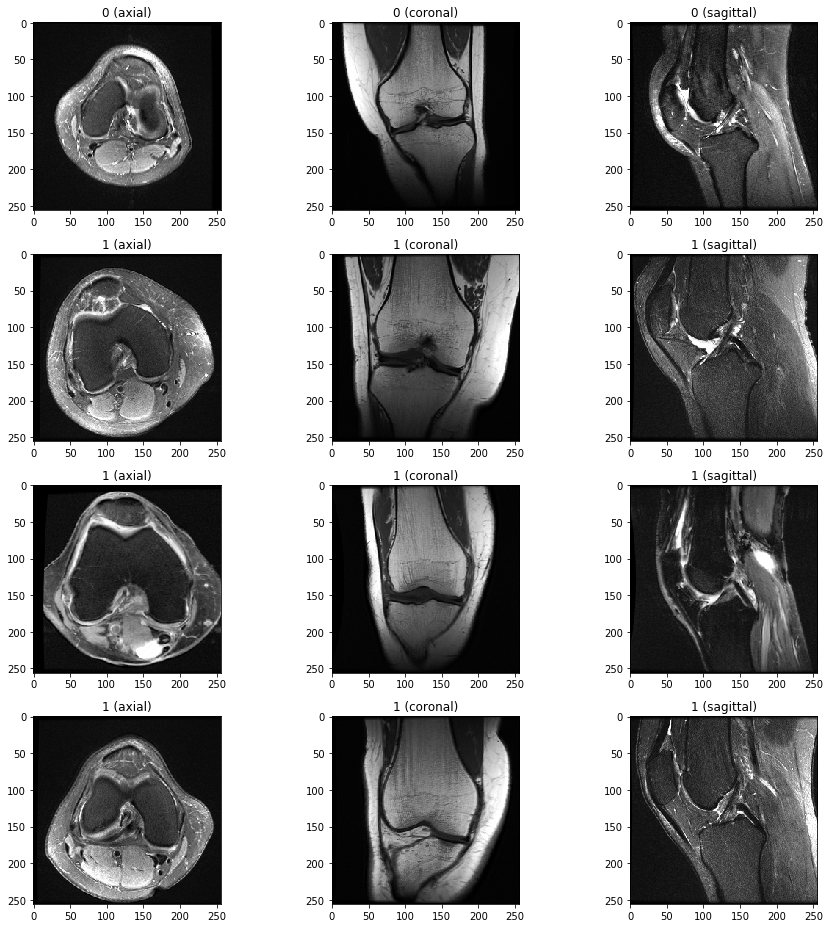

In [15]:
data.show_batch(4)

In [16]:
x,y = data.one_batch(DatasetType.Train, True, True)

In [17]:
x.shape, y.shape

(torch.Size([8, 3, 24, 256, 256]), torch.Size([8]))

In [18]:
smpl = grab_idx(x, 2)
smpl.shape, type(smpl)

(torch.Size([3, 24, 256, 256]), torch.Tensor)

Calling `.reconstruct` on the PyTorch Tensor returns the same kind of thing as the `.get` method, which in this context is an `MRNetCase`, which we can then display. 

In [19]:
tst = data.train_ds.x.reconstruct(smpl)

In [20]:
type(tst)

mrnet_itemlist.MRNetCase

In [21]:
tst


        MRNetCase 
        `obj` attribute is tuple(axial, coronal, sagittal): 
        [(24, 256, 256), (24, 256, 256), (24, 256, 256)]
            
        `data` attribute is all three planar scan data arrays, 
        with variations in slice count removed via interpolation
        (3, 24, 256, 256)
        [[[[ 0  0  0  0 ...  1  4  5  6]
   [ 0  0  0  0 ...  6  4  3  5]
   [ 0  0  0  0 ... 10  8  3  5]
   [ 0  0  0  3 ...  7  8  4  8]
   ...
   [12  7  2 10 ...  2  0  2  0]
   [ 5  0  9  6 ...  4  5  7  3]
   [ 0  0  2  0 ...  3  3  4  0]
   [ 0  0  0  0 ...  3  1  0  3]]

  [[ 0  0  0  0 ...  4  4  3  7]
   [ 0  0  0  0 ...  4 10 10  8]
   [ 0  0  0  0 ...  8 12 11  8]
   [ 0  0  0  0 ... 12  7 10  2]
   ...
   [ 2  5 17  6 ...  8  6  3  5]
   [ 0  1  4  5 ... 10  7  4  7]
   [ 0  0  0  0 ...  3  5  2  8]
   [ 0  0  0  0 ...  1  2  3  6]]

  [[ 0  0  0  0 ... 18 16 15 18]
   [ 0  0  0  0 ... 18 15 15 15]
   [ 0  0  0  0 ... 15 16 14 16]
   [ 0  0  0  0 ... 16 15 14 22]
   ...
 

In [22]:
tst.data.shape

(3, 24, 256, 256)

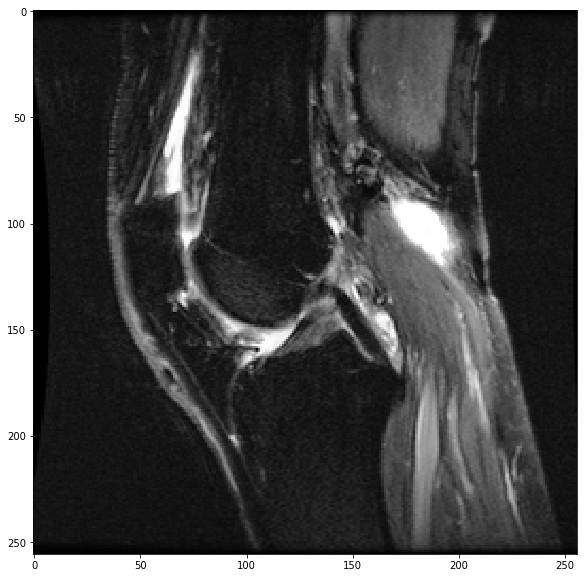

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(tst.data[2, 11, :, :])
plt.show()

### Minimal training example
- [x] import necessary libraries (fastai, mrnet_itemlist)
- [x] https://docs.fast.ai/data_block.html
- [x] 1 provide inputs
- [x] 2 split data into training and validation sets
- [x] 3 label the inputs
- [ ] 4 what transforms to apply (none for now)
- [ ] 5 how to add test set (none for now)
- [x] 6 how to wrap in dataloaders and create the databunch